<a href="https://colab.research.google.com/github/AngelicaCeDi/Analitica-3-caso-salud/blob/main/C_Modelacion_red_neuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#IMPORTAR PAQUETES
import sqlite3 as sql
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns 
from imblearn.over_sampling import SMOTE
import os
os.getcwd()

'/content'

In [33]:
!git clone "https://github.com/AngelicaCeDi/Analitica-3-Caso-salud.git" 

fatal: destination path 'Analitica-3-Caso-salud' already exists and is not an empty directory.


In [34]:
os.chdir('/content') 

In [35]:
#Conexión con la base de datos.
conn= sql.connect("/content/Analitica-3-Caso-salud/strokeb.db") 
cur=conn.cursor()

In [36]:
#Exploramos que tablas que hay en el sql. 
cur.execute("SELECT name FROM sqlite_master where type='table' ")
cur.fetchall()

[('stroke',)]

In [37]:
pd.read_sql("SELECT * FROM stroke",conn).head()

,index,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,1,1,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
2,2,0,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
3,3,0,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1
4,4,1,81.0,0,0,1,Private,1,186.21,29.0,formerly smoked,1


In [40]:
#Volver dummies las variables categoricas.
df=pd.read_sql("SELECT work_type, smoking_status FROM stroke",conn)
df_dummies=pd.get_dummies(df)

In [41]:
dfbi=pd.read_sql("SELECT gender,	hypertension,	heart_disease, Residence_type,	ever_married FROM stroke",conn)
pre=pd.concat([pd.DataFrame(dfbi), pd.DataFrame(df_dummies)], axis = 1)

In [42]:
pre.head()

,gender,hypertension,heart_disease,Residence_type,ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,0,1,1,1,0,1,0,0,0,1,0,0
1,1,0,1,0,1,0,1,0,0,0,0,1,0
2,0,0,0,1,1,0,1,0,0,0,0,0,1
3,0,1,0,0,1,0,0,1,0,0,0,1,0
4,1,0,0,1,1,0,1,0,0,0,1,0,0


In [43]:
#Estandarizamos los datos númericos y creamos la tabla con los features necesarios.
#Variables númericas.
df2=pd.read_sql("SELECT age, avg_glucose_level,	bmi FROM stroke",conn)
#Escalando las variables age, avg_glucose_level y bmi entre un rango con MinMaxScaler.
min_max_scaler = preprocessing.MinMaxScaler()
df2sc = min_max_scaler.fit_transform(df2)
#Restablecemos el nombre de las columnas.
df2sc= pd.DataFrame(df2sc)
df2sc.columns=df2.columns

In [44]:
features=pd.concat([pd.DataFrame(df2sc), pd.DataFrame(pre)], axis = 1)
features.head()

,age,avg_glucose_level,bmi,gender,hypertension,heart_disease,Residence_type,ever_married,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.816895,0.801265,0.647564,1,0,1,1,1,0,1,0,0,0,1,0,0
1,0.975586,0.234512,0.530086,1,0,1,0,1,0,1,0,0,0,0,1,0
2,0.597168,0.536008,0.584527,0,0,0,1,1,0,1,0,0,0,0,0,1
3,0.963379,0.549349,0.286533,0,1,0,0,1,0,0,1,0,0,0,1,0
4,0.987793,0.605161,0.429799,1,0,0,1,1,0,1,0,0,0,1,0,0


In [45]:
#Creación de los conjuntos de X y y para la red neuronal.
X=features.copy()
y=pd.read_sql("SELECT stroke FROM stroke",conn)


In [46]:
#Separación de lso conjuntos de entrenamiento y testeo. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #80% de los datos para entrenamiento y 20% de los datos para testeo.


In [47]:
X_train.shape

(3486, 16)

Tecnica de oversampling con SMOTE para balancear clases (En este caso la clase positiva a ACV calificada con 1 en la variable 'stroke') Esto solo se aplica a las muestras de entrenamiento para evitar tener datos sinteticos a la hora de testear el modelo.



In [48]:
sm=SMOTE()
X_tsm,y_tsm=sm.fit_resample(X_train,y_train)
print(f'''Cambio de X antes de SMOTE: {X_train.shape} 
      Cambio de X despues de SMOTE: {X_tsm.shape} ''')
print('balance negativo y positivo de clases (%) ')
y_tsm.value_counts(normalize=True)*100

Cambio de X antes de SMOTE: (3486, 16) 
      Cambio de X despues de SMOTE: (6618, 16) 
balance negativo y positivo de clases (%) 


stroke
0         50.0
1         50.0
dtype: float64

Text(0.5, 1.0, 'Datos balanceados')

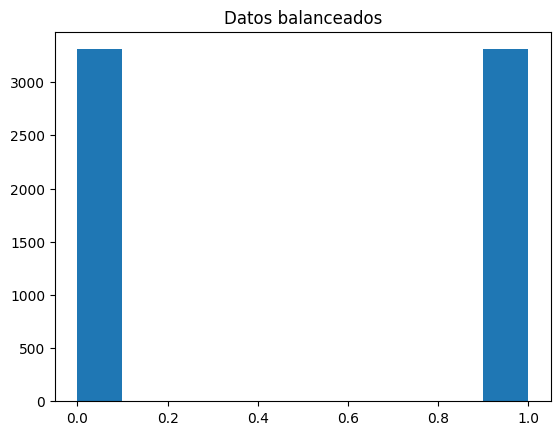

In [49]:
plt.hist(y_tsm)
plt.title('Datos balanceados')

In [50]:
#Volvemos las particiones en un array.
X_tsm=X_tsm.values
X_test=X_test.values
y_tsm=y_tsm.values
y_test=y_test.values

In [51]:
from tensorflow.python.ops.gen_nn_ops import relu
#Arquitectura de la red neuronal.
capaEntrada= tf.keras.layers.Dense(units=20, input_shape=[16], activation='relu')
capaOculta1=tf.keras.layers.Dense(units=15,activation='relu')
capaOculta2=tf.keras.layers.Dense(units=8,activation='relu')
capaSalida=tf.keras.layers.Dense(units=1,activation='sigmoid')

In [52]:
#Determinación del modelo.
modelo=tf.keras.Sequential((capaEntrada, capaOculta1,capaOculta2, capaSalida))

In [53]:
#Compilación del modelo.
modelo.compile(optimizer=tf.keras.optimizers.Adam(0.05),
               loss='binary_crossentropy',metrics=['binary_accuracy','Recall']) # La función Adam toma la tasa de aprendizaje y de manera eficiente ira ajustando los pesos y el sesgo para que el aprendizaje sea lo más correcto posible, 
#para la función de perdida usamos 'binary_crossentropy' la cual rastrea el etiquetado incorrecto de la clase por parte de un modelo, lo que penaliza el modelo si se producen desviaciones en la probabilidad de clasificar las etiquetas.  
#'binary_accuracy' calcula la frecuencia con la que se ha acertado una predicción para ACV, es muy utilizada para problemas de clasificación binaria.
#'recall' calcula la tasa de identificación de pacientes que pueden presentar un ACV. Para el problema es más importante los positivos a presentar un ACV y 
#los falsos negativos pues puede significar el desconocimiento de la patologia para un paciente.

In [54]:
#Entrenamos la red neuronal.
print('Inicio de entrenamiento...')
resultados= modelo.fit(X_tsm,y_tsm, batch_size=700,epochs=150,validation_data=(X_test,y_test)) #Se entra el modelo con los features y los target, 
#con la variable epochs le indicamos cuantas veces entrenar la red, y con la variable batch_size le indicamos la porción de datos a entrenar en cada epoca.

print('¡Modelo entrenado! ')

Inicio de entrenamiento...
Epoch 1/150
10/10 [==============================] - 1s 29ms/step - loss: 0.6327 - binary_accuracy: 0.6269 - recall: 0.6875 - val_loss: 0.5280 - val_binary_accuracy: 0.6763 - val_recall: 0.8028
Epoch 2/150
10/10 [==============================] - 0s 8ms/step - loss: 0.4865 - binary_accuracy: 0.7693 - recall: 0.8432 - val_loss: 0.3573 - val_binary_accuracy: 0.7953 - val_recall: 0.7183
Epoch 3/150
10/10 [==============================] - 0s 7ms/step - loss: 0.4277 - binary_accuracy: 0.8092 - recall: 0.8755 - val_loss: 0.5224 - val_binary_accuracy: 0.7191 - val_recall: 0.8169
Epoch 4/150
10/10 [==============================] - 0s 6ms/step - loss: 0.4023 - binary_accuracy: 0.8208 - recall: 0.8855 - val_loss: 0.4868 - val_binary_accuracy: 0.7217 - val_recall: 0.7465
Epoch 5/150
10/10 [==============================] - 0s 9ms/step - loss: 0.3874 - binary_accuracy: 0.8274 - recall: 0.9024 - val_loss: 0.4462 - val_binary_accuracy: 0.7445 - val_recall: 0.6479
Epoch 6

In [55]:
#Predicciones
predictions=modelo.predict(X_test).round()

47/47 [==============================] - 0s 1ms/step


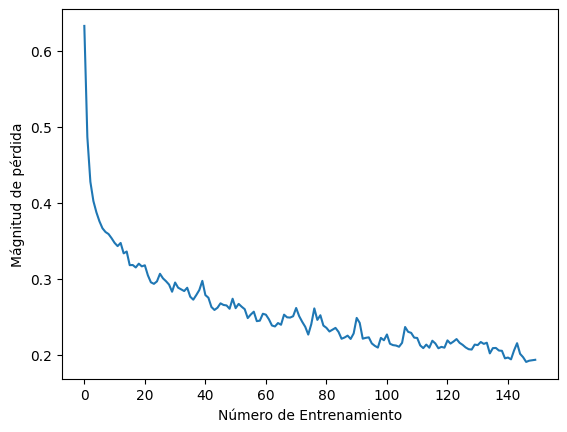

In [56]:
#Analisis del modelo.
plt.xlabel('Número de Entrenamiento')
plt.ylabel('Mágnitud de pérdida')
plt.plot(resultados.history['loss'])


In [57]:
#Analisis del modelo.
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1424
           1       0.08      0.25      0.12        71

    accuracy                           0.82      1495
   macro avg       0.52      0.55      0.51      1495
weighted avg       0.92      0.82      0.86      1495



In [58]:
#Confusión matrix de las predicciones del modelo.
print(confusion_matrix(y_test,predictions))

[[1204  220]
 [  53   18]]


In [59]:
#Guardamos el modelo
modelo.save('/content/modeloACV.h5')
